# Testing BERScore to Evaluate Caption Quality
This notebook explores how well BERTScore can be used to understand caption quality across models.

In [1]:
import json
import copy

import statistics as s
from bert_score import score
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

%load_ext jupyter_black

# Load Data

In [2]:
# load in combined caption data
captioned_data = None
filepath = "../data/study-2-output/labeled-data/combined-caption-output/combined-caption-output_7304-images_2025-03-29_21:40:00.json"
with open(
    filepath,
    "r",
) as f:
    captioned_data = json.load(f)
captioned_data[0:1]

[{'image_id': 1,
  'file_name': 'VizWiz_train_00000001.jpg',
  'vizwiz_url': 'https://vizwiz.cs.colorado.edu/VizWiz_visualization_img/VizWiz_train_00000001.jpg',
  'text_detected': True,
  'unrecognizable': 0,
  'framing': 0,
  'blur': 5,
  'obstruction': 0,
  'rotation': 0,
  'too dark': 0,
  'too bright': 0,
  'other': 0,
  'no issue': 0,
  'human_captions': [{'caption': 'A can of Coca Cola on a counter is shown for when one can use a nice, cold drink.',
    'is_precanned': False,
    'is_rejected': False},
   {'caption': 'A black can of Coca Cola Zero calorie soda is on the counter near the coffee maker.',
    'is_precanned': False,
    'is_rejected': False},
   {'caption': 'A kitchen counter the various items on top including a can of Coca-Cola, metal containers, and a teapot.',
    'is_precanned': False,
    'is_rejected': False},
   {'caption': 'a black tin of Coca Cola placed on a black surface',
    'is_precanned': False,
    'is_rejected': False},
   {'caption': 'Black counter

# Helper functions

In [23]:
def compute_bertscore(
    dataset,
    model_type="microsoft/deberta-xlarge-mnli",
    lang="en",
    rescale_with_baseline=False,
):
    """
    Computes BERTScore for each model against human captions as reference.
    Saves precision, recall, and f1 scores by reference to original input.
    """
    for image in tqdm(dataset):
        curr_references = [
            caption["caption"]
            for caption in image["human_captions"]
            if caption["caption"]
            != "Quality issues are too severe to recognize visual content."
        ]
        curr_output = {}
        for model in image["model_captions"]:
            curr_model_name = model["model_name"]

            # compute scores for current model
            curr_candidate = [model["caption"]]
            P, R, F1 = score(
                curr_candidate,
                [curr_references],
                model_type=model_type,
                lang=lang,
                rescale_with_baseline=rescale_with_baseline,
            )
            curr_output[curr_model_name] = {
                "scores": {
                    "precision": float(P[0]),
                    "recall": float(R[0]),
                    "f1": float(F1[0]),
                }
            }

        # check if evaluation exists and save score
        if "evaluation" not in image:
            image["evaluation"] = {}
        image["evaluation"]["bertscore"] = curr_output

In [24]:
def compute_average_metrics_bertscore(dataset):
    """
    Computes average precision, recall, and f1 for BERTScore for each model.
    """
    total_scores = {}
    for image in dataset:
        curr_evaluation = image["evaluation"]["bertscore"]
        for model_name, scores in curr_evaluation.items():
            scores = scores["scores"]
            if model_name in total_scores:
                total_scores[model_name] = {
                    "total_count": total_scores[model_name]["total_count"] + 1,
                    "total_precision": total_scores[model_name]["total_precision"]
                    + scores["precision"],
                    "total_recall": total_scores[model_name]["total_recall"]
                    + scores["recall"],
                    "total_f1": total_scores[model_name]["total_f1"] + scores["f1"],
                }
            else:
                total_scores[model_name] = {
                    "total_count": 1,
                    "total_precision": scores["precision"],
                    "total_recall": scores["recall"],
                    "total_f1": scores["f1"],
                }

    # compute averages and f1
    output = {}
    for model_name, values in total_scores.items():
        output[model_name] = {
            "avg_precision": values["total_precision"] / float(values["total_count"]),
            "avg_recall": values["total_recall"] / float(values["total_count"]),
            "avg_f1": values["total_f1"] / float(values["total_count"]),
        }
        output[model_name]["f1"] = s.harmonic_mean(
            [output[model_name]["avg_precision"], output[model_name]["avg_recall"]]
        )

    return output

In [25]:
def compute_bertscore_with_list(
    data_input,
    model_type="microsoft/deberta-xlarge-mnli",
    lang="en",
    rescale_with_baseline=False,
):
    # make a deepcopy
    data_input = copy.deepcopy(data_input)
    # TODO: try to use this optimization for all metrics
    # construct input to sentence bert [[list of captions], [[references], references]]
    candidates = {}
    references = []
    for image in data_input:
        curr_references = [
            caption["caption"]
            for caption in image["human_captions"]
            if caption["caption"]
            != "Quality issues are too severe to recognize visual content."
        ]

        for model in image["model_captions"]:
            curr_model_name = model["model_name"]

            # compute scores for current model
            curr_candidate = model["caption"]
            if curr_model_name not in candidates:
                candidates[curr_model_name] = [curr_candidate]
            else:
                candidates[curr_model_name].append(curr_candidate)

        references.append(curr_references)

    bertscore_output_per_model = {}
    for model_name in candidates.keys():
        P_lst, R_lst, F1_lst = score(
            candidates[model_name],
            references,
            model_type=model_type,
            lang=lang,
            rescale_with_baseline=rescale_with_baseline,
        )
        bertscore_output_per_model[model_name] = {
            "precision": P_lst,
            "recall": R_lst,
            "f1": F1_lst,
        }

    # convert lists into formatted output for data_input
    bertscore_outputs = {}
    for model_name in candidates.keys():
        curr_output = []
        for P, R, F1 in zip(
            bertscore_output_per_model[model_name]["precision"],
            bertscore_output_per_model[model_name]["recall"],
            bertscore_output_per_model[model_name]["f1"],
        ):
            curr_output.append(
                {
                    "scores": {
                        "precision": float(P),
                        "recall": float(R),
                        "f1": float(F1),
                    }
                }
            )
        bertscore_outputs[model_name] = curr_output

    # attach bertscore outputs to data_input
    for index, image in enumerate(data_input):
        curr_output = {}
        for model_name in bertscore_outputs.keys():
            curr_output[model_name] = bertscore_outputs[model_name][index]
        if "evaluation" not in image:
            image["evaluation"] = {}
        image["evaluation"]["bertscore"] = curr_output

    return data_input

In [26]:
limit = 10
model_type = "microsoft/deberta-xlarge-mnli"
compute_average_metrics_bertscore(
    compute_bertscore_with_list(captioned_data[0:limit], model_type=model_type)
)

{'gpt-4o-2024-08-06': {'avg_precision': 0.6272800326347351,
  'avg_recall': 0.780607956647873,
  'avg_f1': 0.6917835056781769,
  'f1': 0.6955948033486935},
 'Llama-3.2-11B-Vision-Instruct': {'avg_precision': 0.6076797425746918,
  'avg_recall': 0.760029011964798,
  'avg_f1': 0.6693472445011139,
  'f1': 0.6753692740609429},
 'Molmo-7B-O-0924': {'avg_precision': 0.6660487473011016,
  'avg_recall': 0.7902890324592591,
  'avg_f1': 0.7159294426441193,
  'f1': 0.7228694158602452}}

# Testing different BERT Models
We initially used `microsoft/deberta-xlarge-mnli` but the scores seemed suspect when examining captions that were clearly poor quality. This exploration looks at different models and sees if there's a model whose scores align with subjective interpretation of captions

In [27]:
def test_bert_models(dataset, rescale_with_baseline=False):
    """
    Test different BERT models on a dataset
    """
    dataset = copy.deepcopy(dataset)

    # test different models
    model_list = [
        "microsoft/deberta-xlarge-mnli",
        "microsoft/deberta-v2-xxlarge-mnli",
        "microsoft/deberta-xlarge",
        "roberta-large-mnli",
        "roberta-large",
    ]
    limit = 10

    output = {}
    for model in tqdm(model_list):
        computed_scores = compute_bertscore_with_list(
            dataset, model_type=model, rescale_with_baseline=rescale_with_baseline
        )
        computed_summary = compute_average_metrics_bertscore(computed_scores)
        output[model] = {
            "data": computed_scores,
            "summary": computed_summary,
        }

    # create a plot showing avg_precision, avg_recall, and f1 for each model
    # Extract data for plotting
    models = list(output.keys())
    llm_models = list(output[models[0]]["summary"].keys())

    # Create a 3x3 grid of subplots (3 rows for LLMs, 3 columns for metrics)
    fig, axes = plt.subplots(len(llm_models), 3, figsize=(25, 5 * len(llm_models)))

    # If there's only one LLM model, axes won't be 2D, so reshape it
    if len(llm_models) == 1:
        axes = axes.reshape(1, -1)

    for row, llm_model in enumerate(llm_models):
        # Plot precision
        axes[row, 0].bar(
            models,
            [output[model]["summary"][llm_model]["avg_precision"] for model in models],
        )
        axes[row, 0].set_title(f"{llm_model} - Average Precision")
        axes[row, 0].set_ylim(0, 1)

        # Plot recall
        axes[row, 1].bar(
            models,
            [output[model]["summary"][llm_model]["avg_recall"] for model in models],
        )
        axes[row, 1].set_title(f"{llm_model} - Average Recall")
        axes[row, 1].set_ylim(0, 1)

        # Plot f1
        axes[row, 2].bar(
            models, [output[model]["summary"][llm_model]["f1"] for model in models]
        )
        axes[row, 2].set_title(f"{llm_model} - F1 Score")
        axes[row, 2].set_ylim(0, 1)

        # Add bar labels to 4 decimal places
        for i, model in enumerate(models):
            axes[row, 0].text(
                i,
                output[model]["summary"][llm_model]["avg_precision"],
                str(f"{output[model]['summary'][llm_model]['avg_precision']:0.4f}"),
                ha="center",
                va="bottom",
            )
            axes[row, 1].text(
                i,
                output[model]["summary"][llm_model]["avg_recall"],
                str(f"{output[model]['summary'][llm_model]['avg_recall']:0.4f}"),
                ha="center",
                va="bottom",
            )
            axes[row, 2].text(
                i,
                output[model]["summary"][llm_model]["f1"],
                str(f"{output[model]['summary'][llm_model]['f1']:0.4f}"),
                ha="center",
                va="bottom",
            )

        # Rotate x-axis labels
        axes[row, 0].set_xticklabels(models, rotation=30, ha="right")
        axes[row, 1].set_xticklabels(models, rotation=30, ha="right")
        axes[row, 2].set_xticklabels(models, rotation=30, ha="right")

    plt.tight_layout()
    plt.show()

    # return the dataset with bertscore outputs and the summarized data per model
    return output

  0%|          | 0/5 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/6w/gkg9vw3d29jglv9knrxxf3r40000gn/T/ipykernel_73544/1262268110.py:89: UserWarning: set_ticklabels() should only

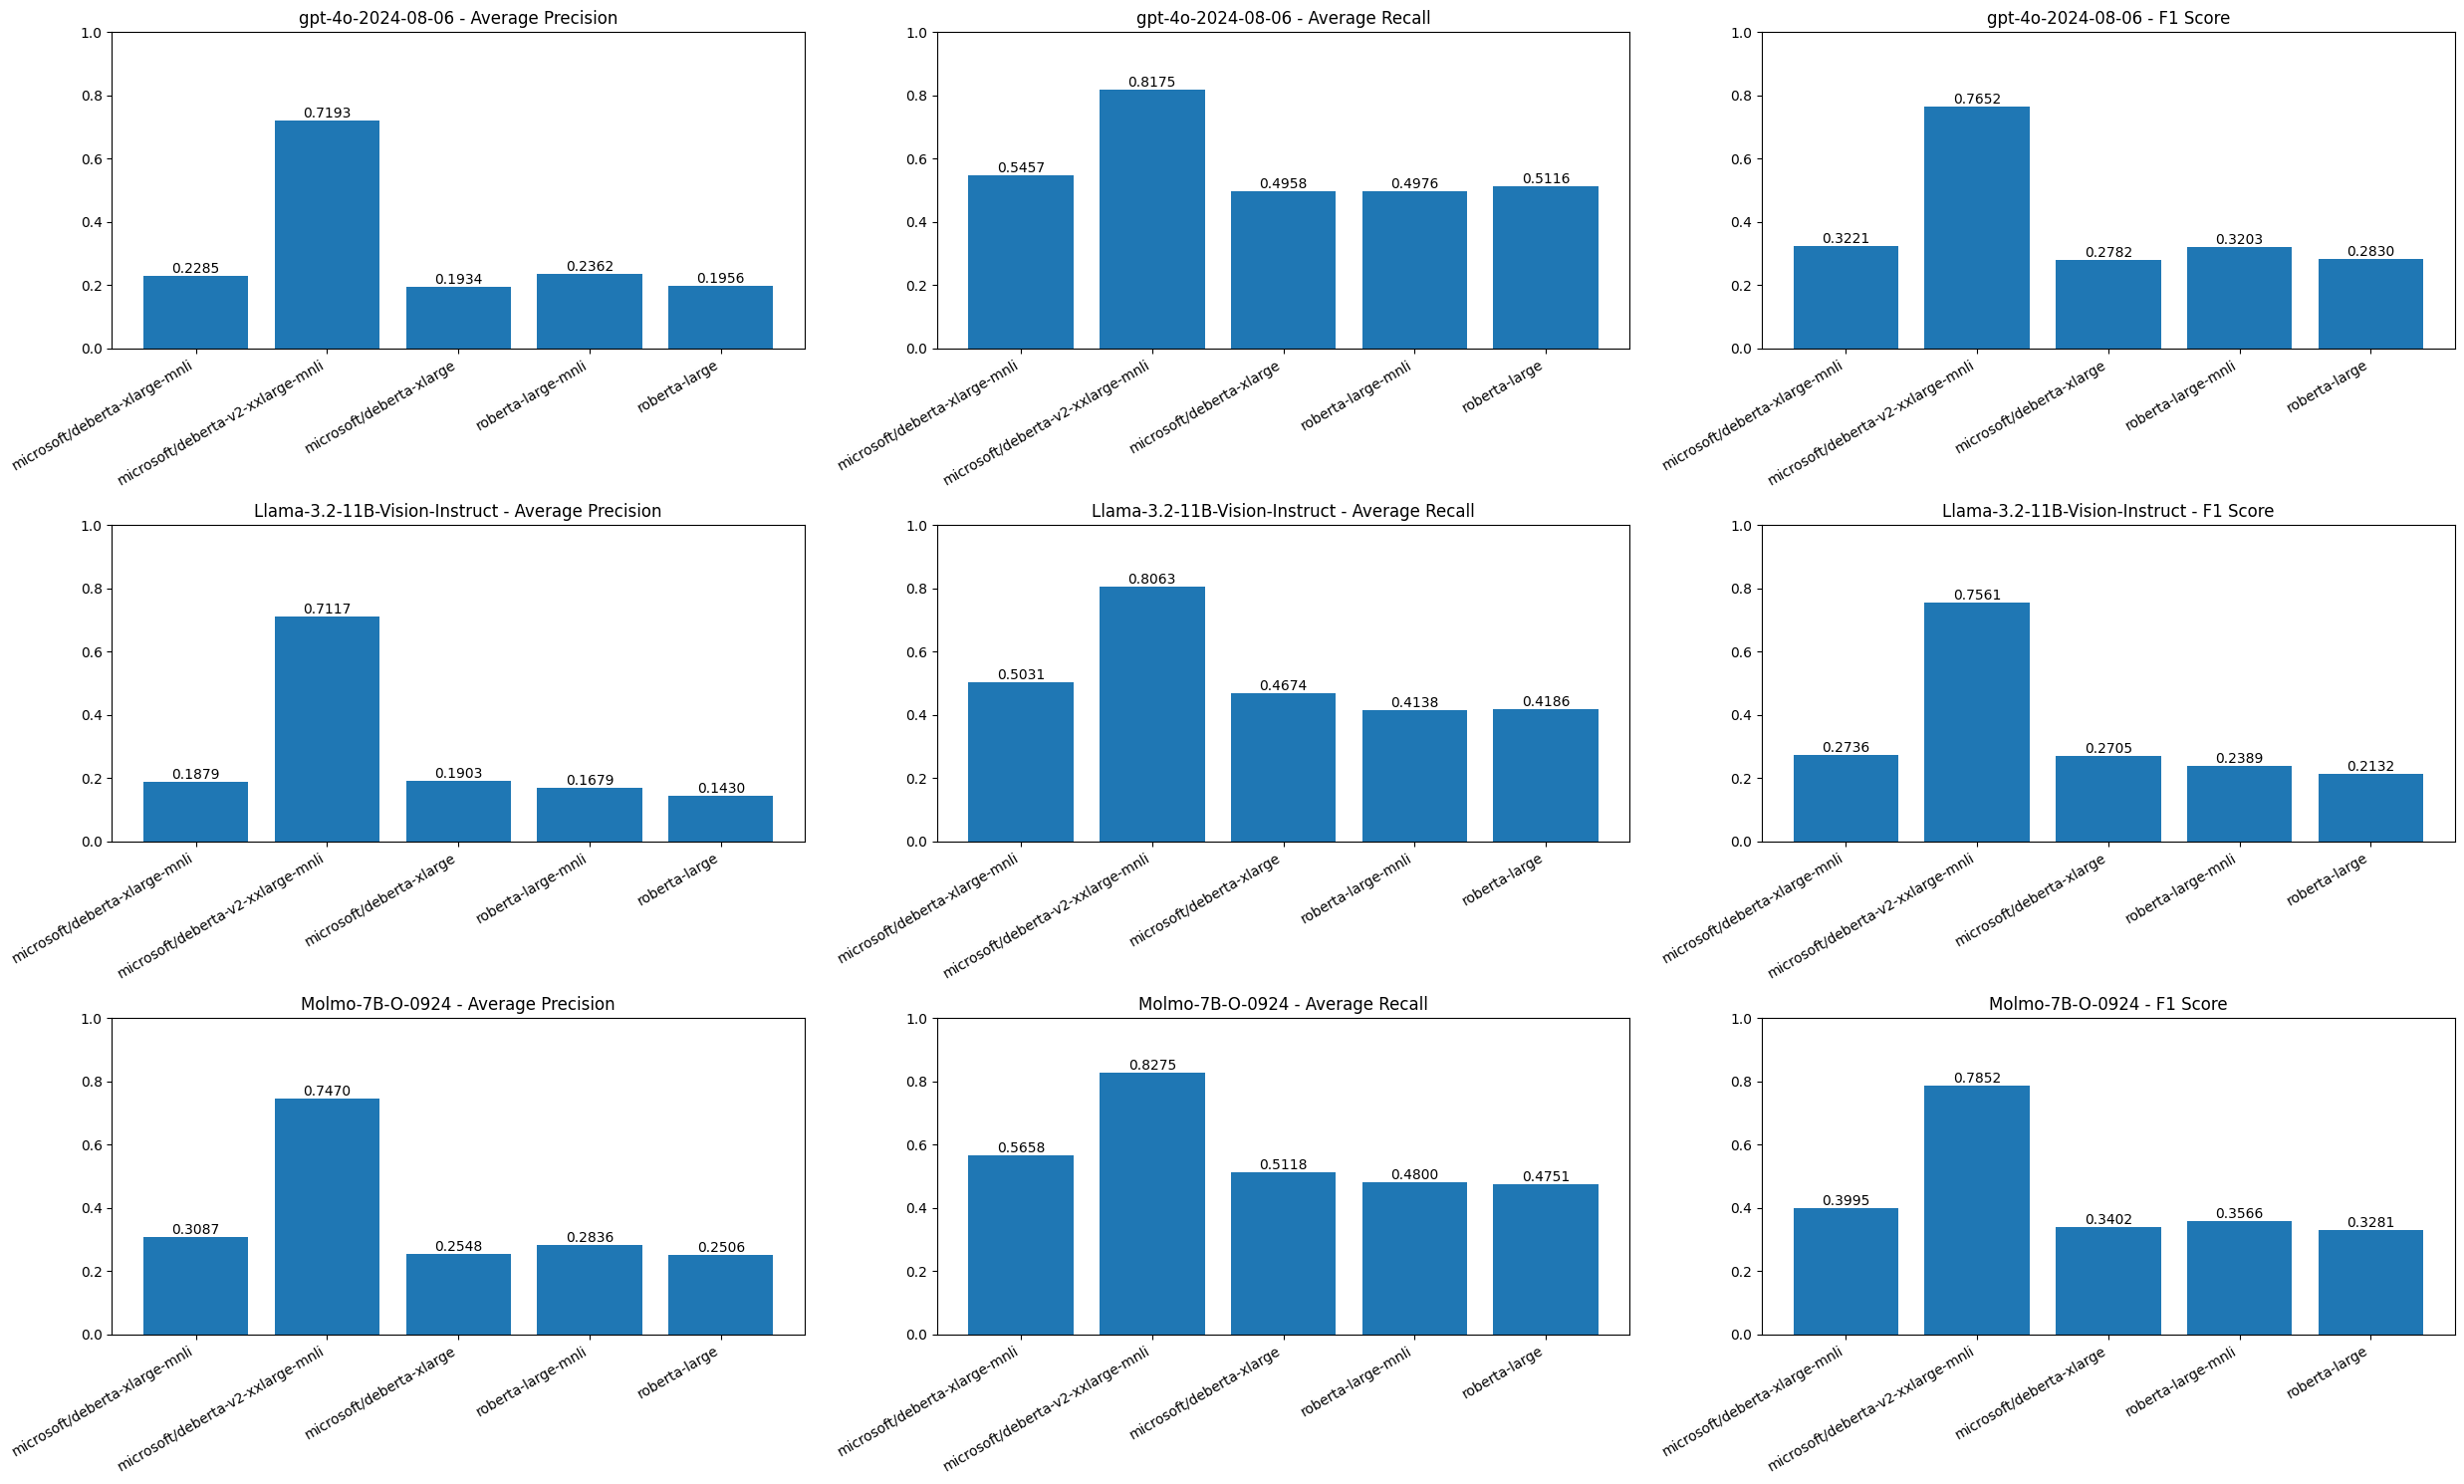

In [82]:
caption_data_bertscores_per_model = test_bert_models(captioned_data[0:limit])

## Test set: similarity in human resposnes
One way to test this data is to look at consistency in human captions. The hypothesis is that BERTScore is sensitive to differences in human captions.

### Test set 1: Low mean similarity of responses
Low mean indciates that human captioners have consensus on what is in the image. This is the best case: people agree on what's in the image.

In [83]:
test_images = [
    "VizWiz_train_00021660.jpg",
    "VizWiz_train_00016884.jpg",
    "VizWiz_train_00013883.jpg",
    "VizWiz_train_00006346.jpg",
    "VizWiz_train_00019576.jpg",
    "VizWiz_train_00014489.jpg",
    "VizWiz_train_00017921.jpg",
    "VizWiz_train_00000764.jpg",
    "VizWiz_train_00020137.jpg",
    "VizWiz_train_00018577.jpg",
]
testset1_captioned_data = [
    image for image in captioned_data if image["file_name"] in test_images
]
len(testset1_captioned_data)

10

  0%|          | 0/5 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/6w/gkg9vw3d29jglv9knrxxf3r40000gn/T/ipykernel_73544/1262268110.py:89: UserWarning: set_ticklabels() should only

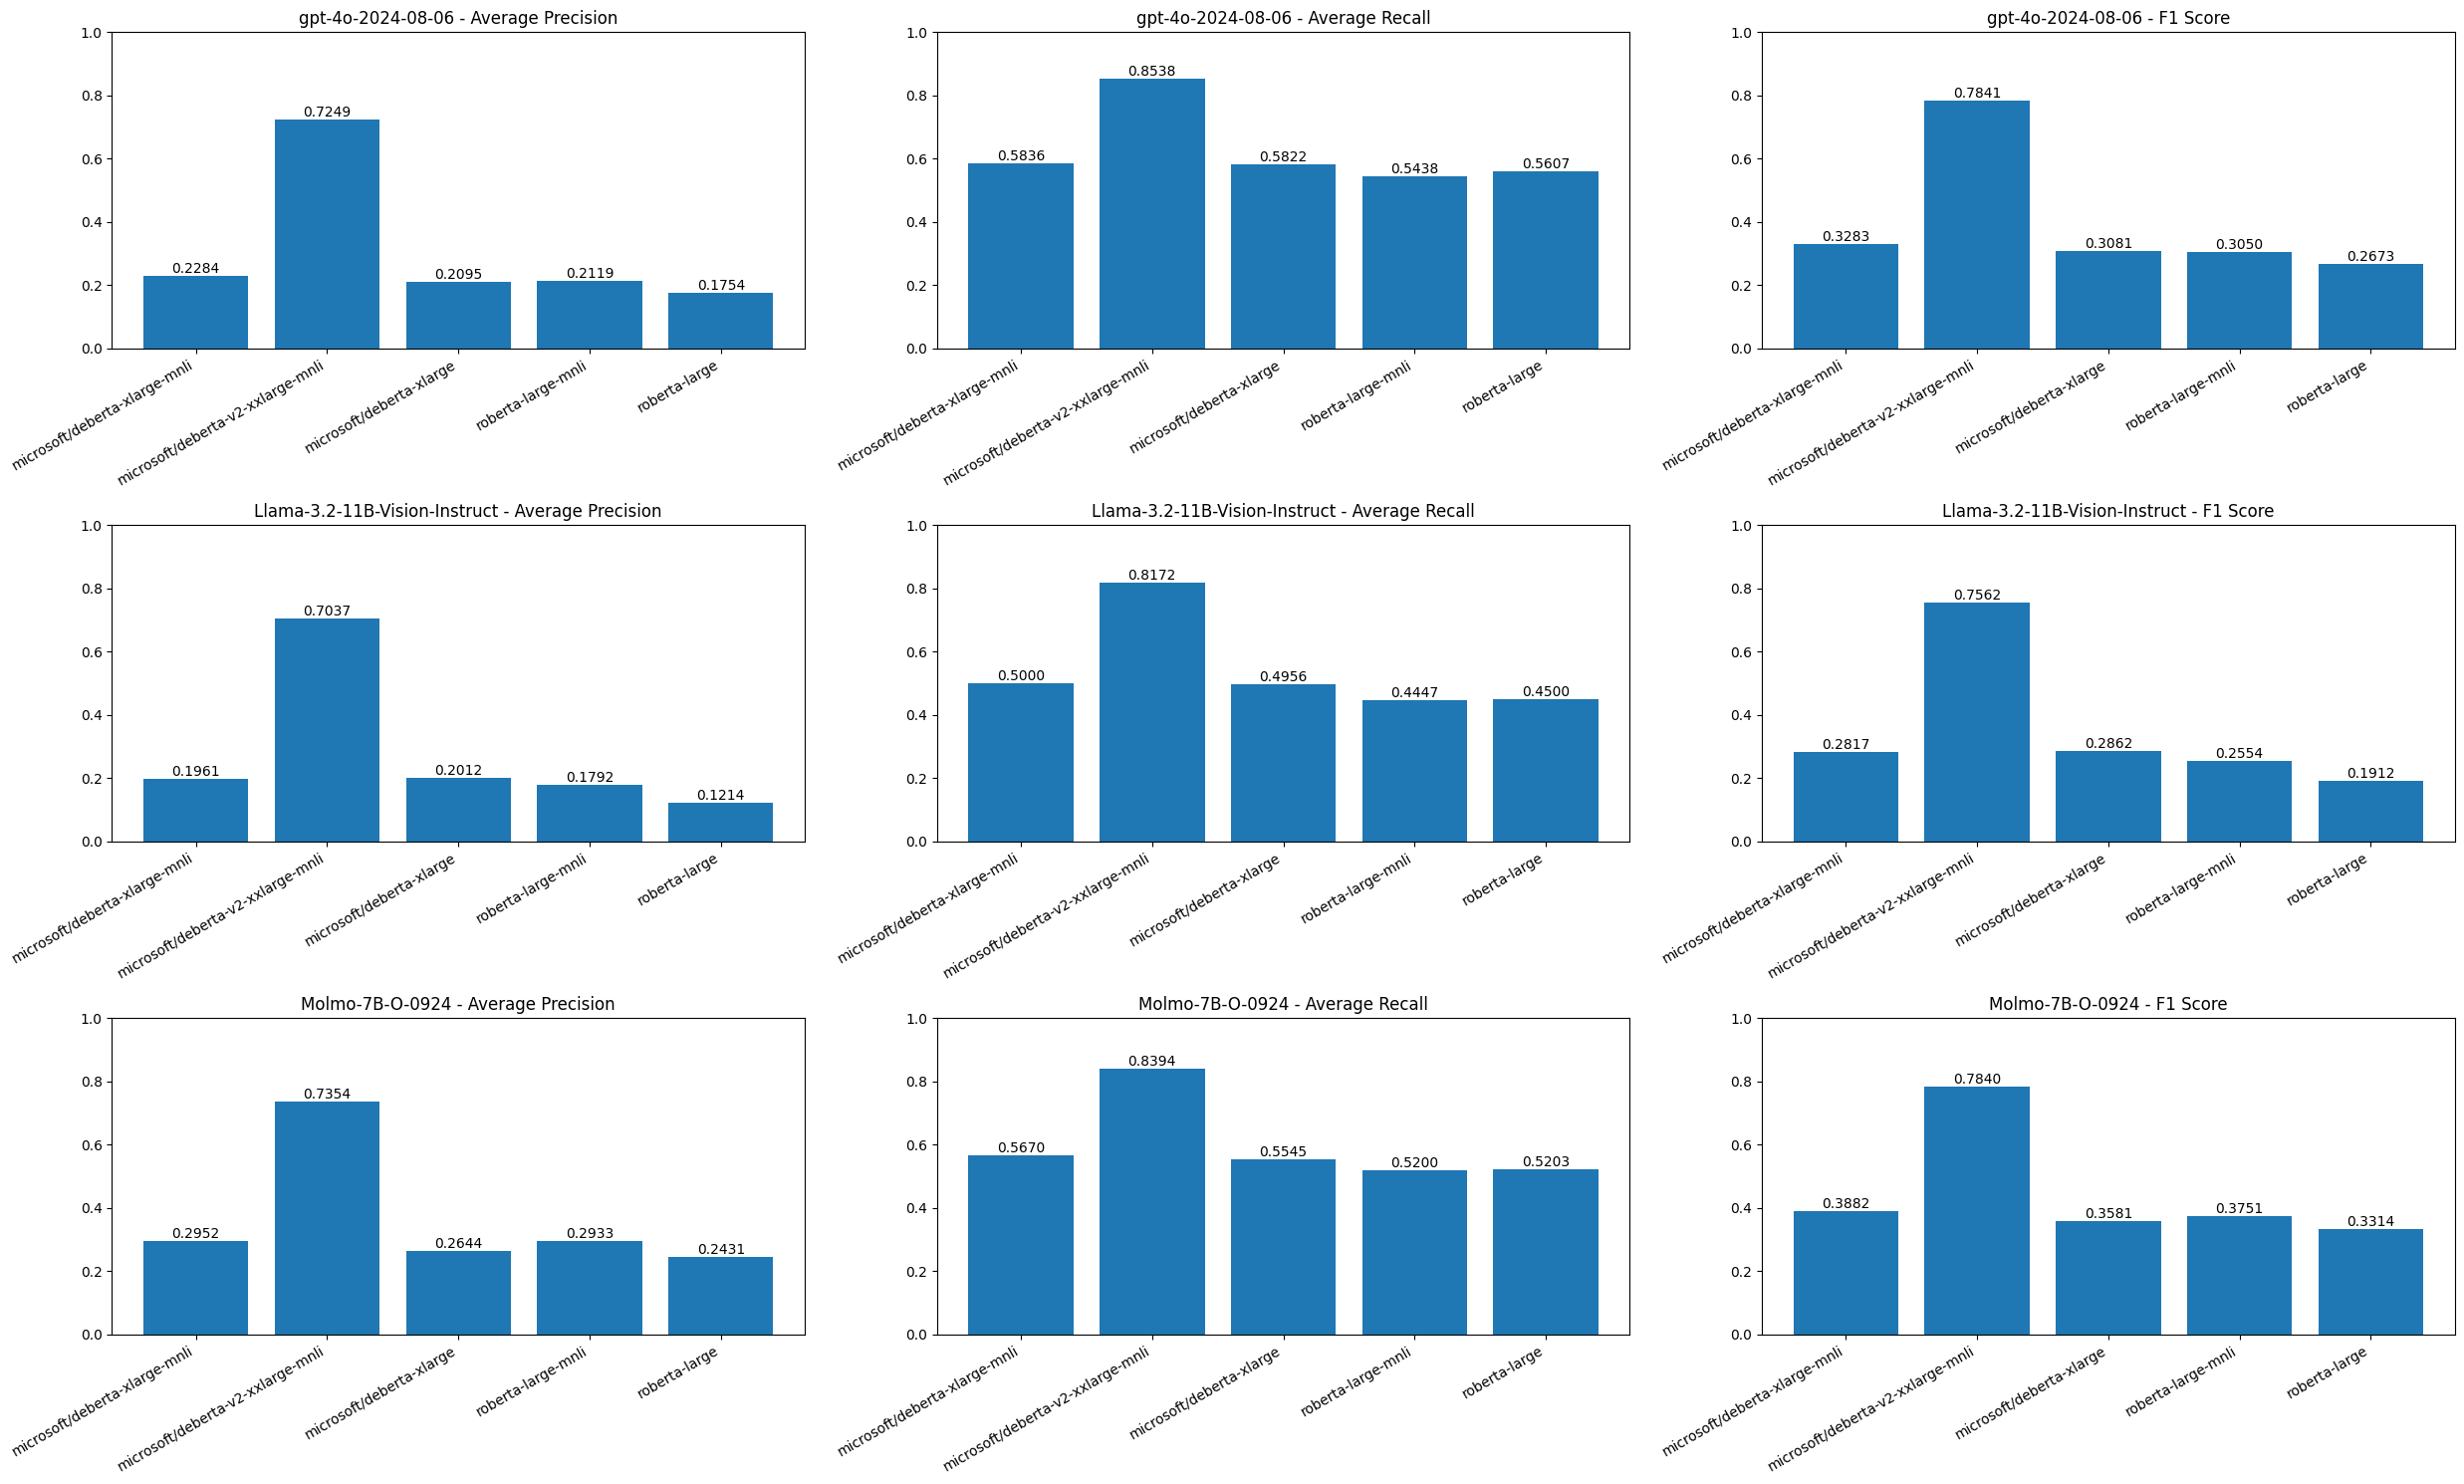

In [84]:
testset1_captioned_bertscores_per_model = test_bert_models(testset1_captioned_data)

### Test set 2: High mean similarity of responses
High mean indicates human captioners disagree on what is in the image. This could result in noisy atomics since there's many different things people are considering are in the image.

In [85]:
test_images = [
    "VizWiz_train_00015945.jpg",
    "VizWiz_train_00015358.jpg",
    "VizWiz_train_00019128.jpg",
    "VizWiz_train_00015003.jpg",
    "VizWiz_train_00005172.jpg",
    "VizWiz_train_00012202.jpg",
    "VizWiz_train_00004022.jpg",
    "VizWiz_train_00023243.jpg",
    "VizWiz_train_00008517.jpg",
    "VizWiz_train_00006718.jpg",
]
testset2_captioned_data = [
    image for image in captioned_data if image["file_name"] in test_images
]
len(testset2_captioned_data)

10

  0%|          | 0/5 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/6w/gkg9vw3d29jglv9knrxxf3r40000gn/T/ipykernel_73544/1262268110.py:89: UserWarning: set_ticklabels() should only

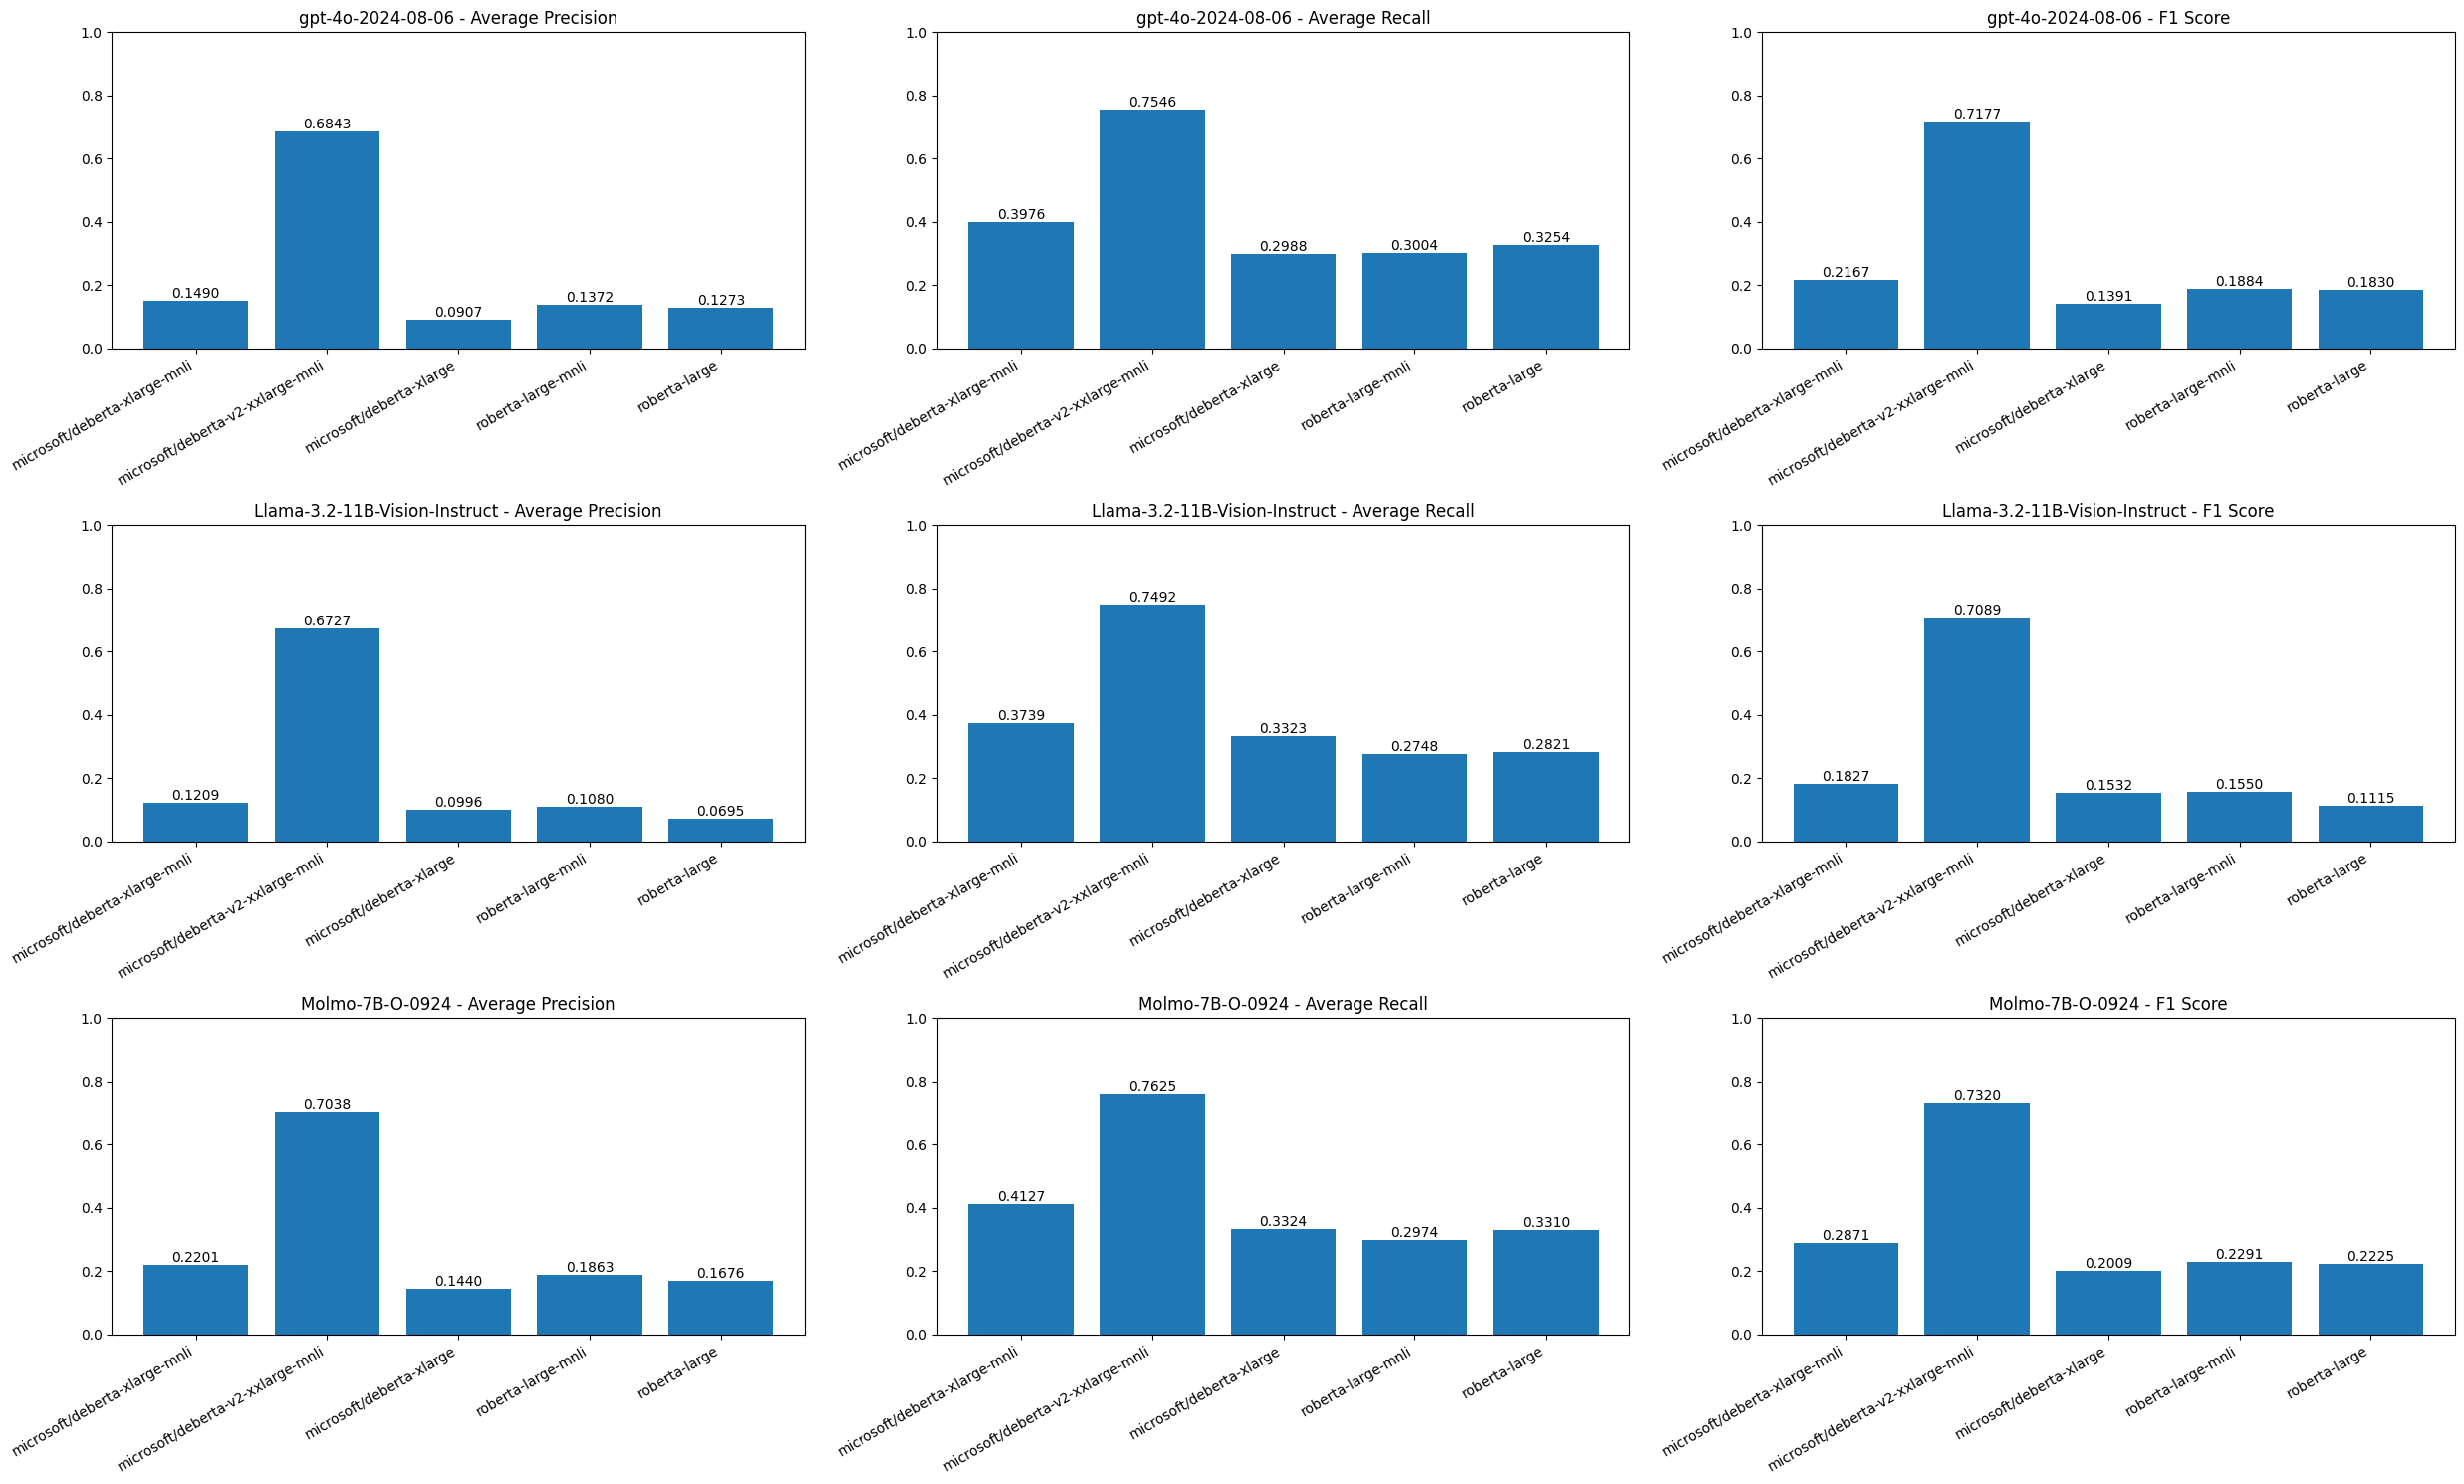

In [86]:
testset2_captioned_bertscores_per_model = test_bert_models(testset2_captioned_data)

### Test set 3: High st. dev in similarity of responses
High stdev indicates there is strong semantic differences between a couple of the captions and the rest. This is a good signal for very irrevalant captions that may introduce noise into captioning. We don't look at low stdev since there's generally fewer responses there (because people abstain), which artificially makes the measure low.

In [93]:
test_images = [
    "VizWiz_train_00012649.jpg",
    "VizWiz_train_00005084.jpg",
    "VizWiz_train_00004622.jpg",
    "VizWiz_train_00017721.jpg",
    "VizWiz_train_00020365.jpg",
    "VizWiz_train_00012829.jpg",
    "VizWiz_train_00005250.jpg",
    "VizWiz_train_00013555.jpg",
    "VizWiz_train_00004547.jpg",
    "VizWiz_train_00006425.jpg",
]
testset3_captioned_data = [
    image for image in captioned_data if image["file_name"] in test_images
]
len(testset3_captioned_data)

10

  0%|          | 0/5 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/6w/gkg9vw3d29jglv9knrxxf3r40000gn/T/ipykernel_73544/1262268110.py:89: UserWarning: set_ticklabels() should only

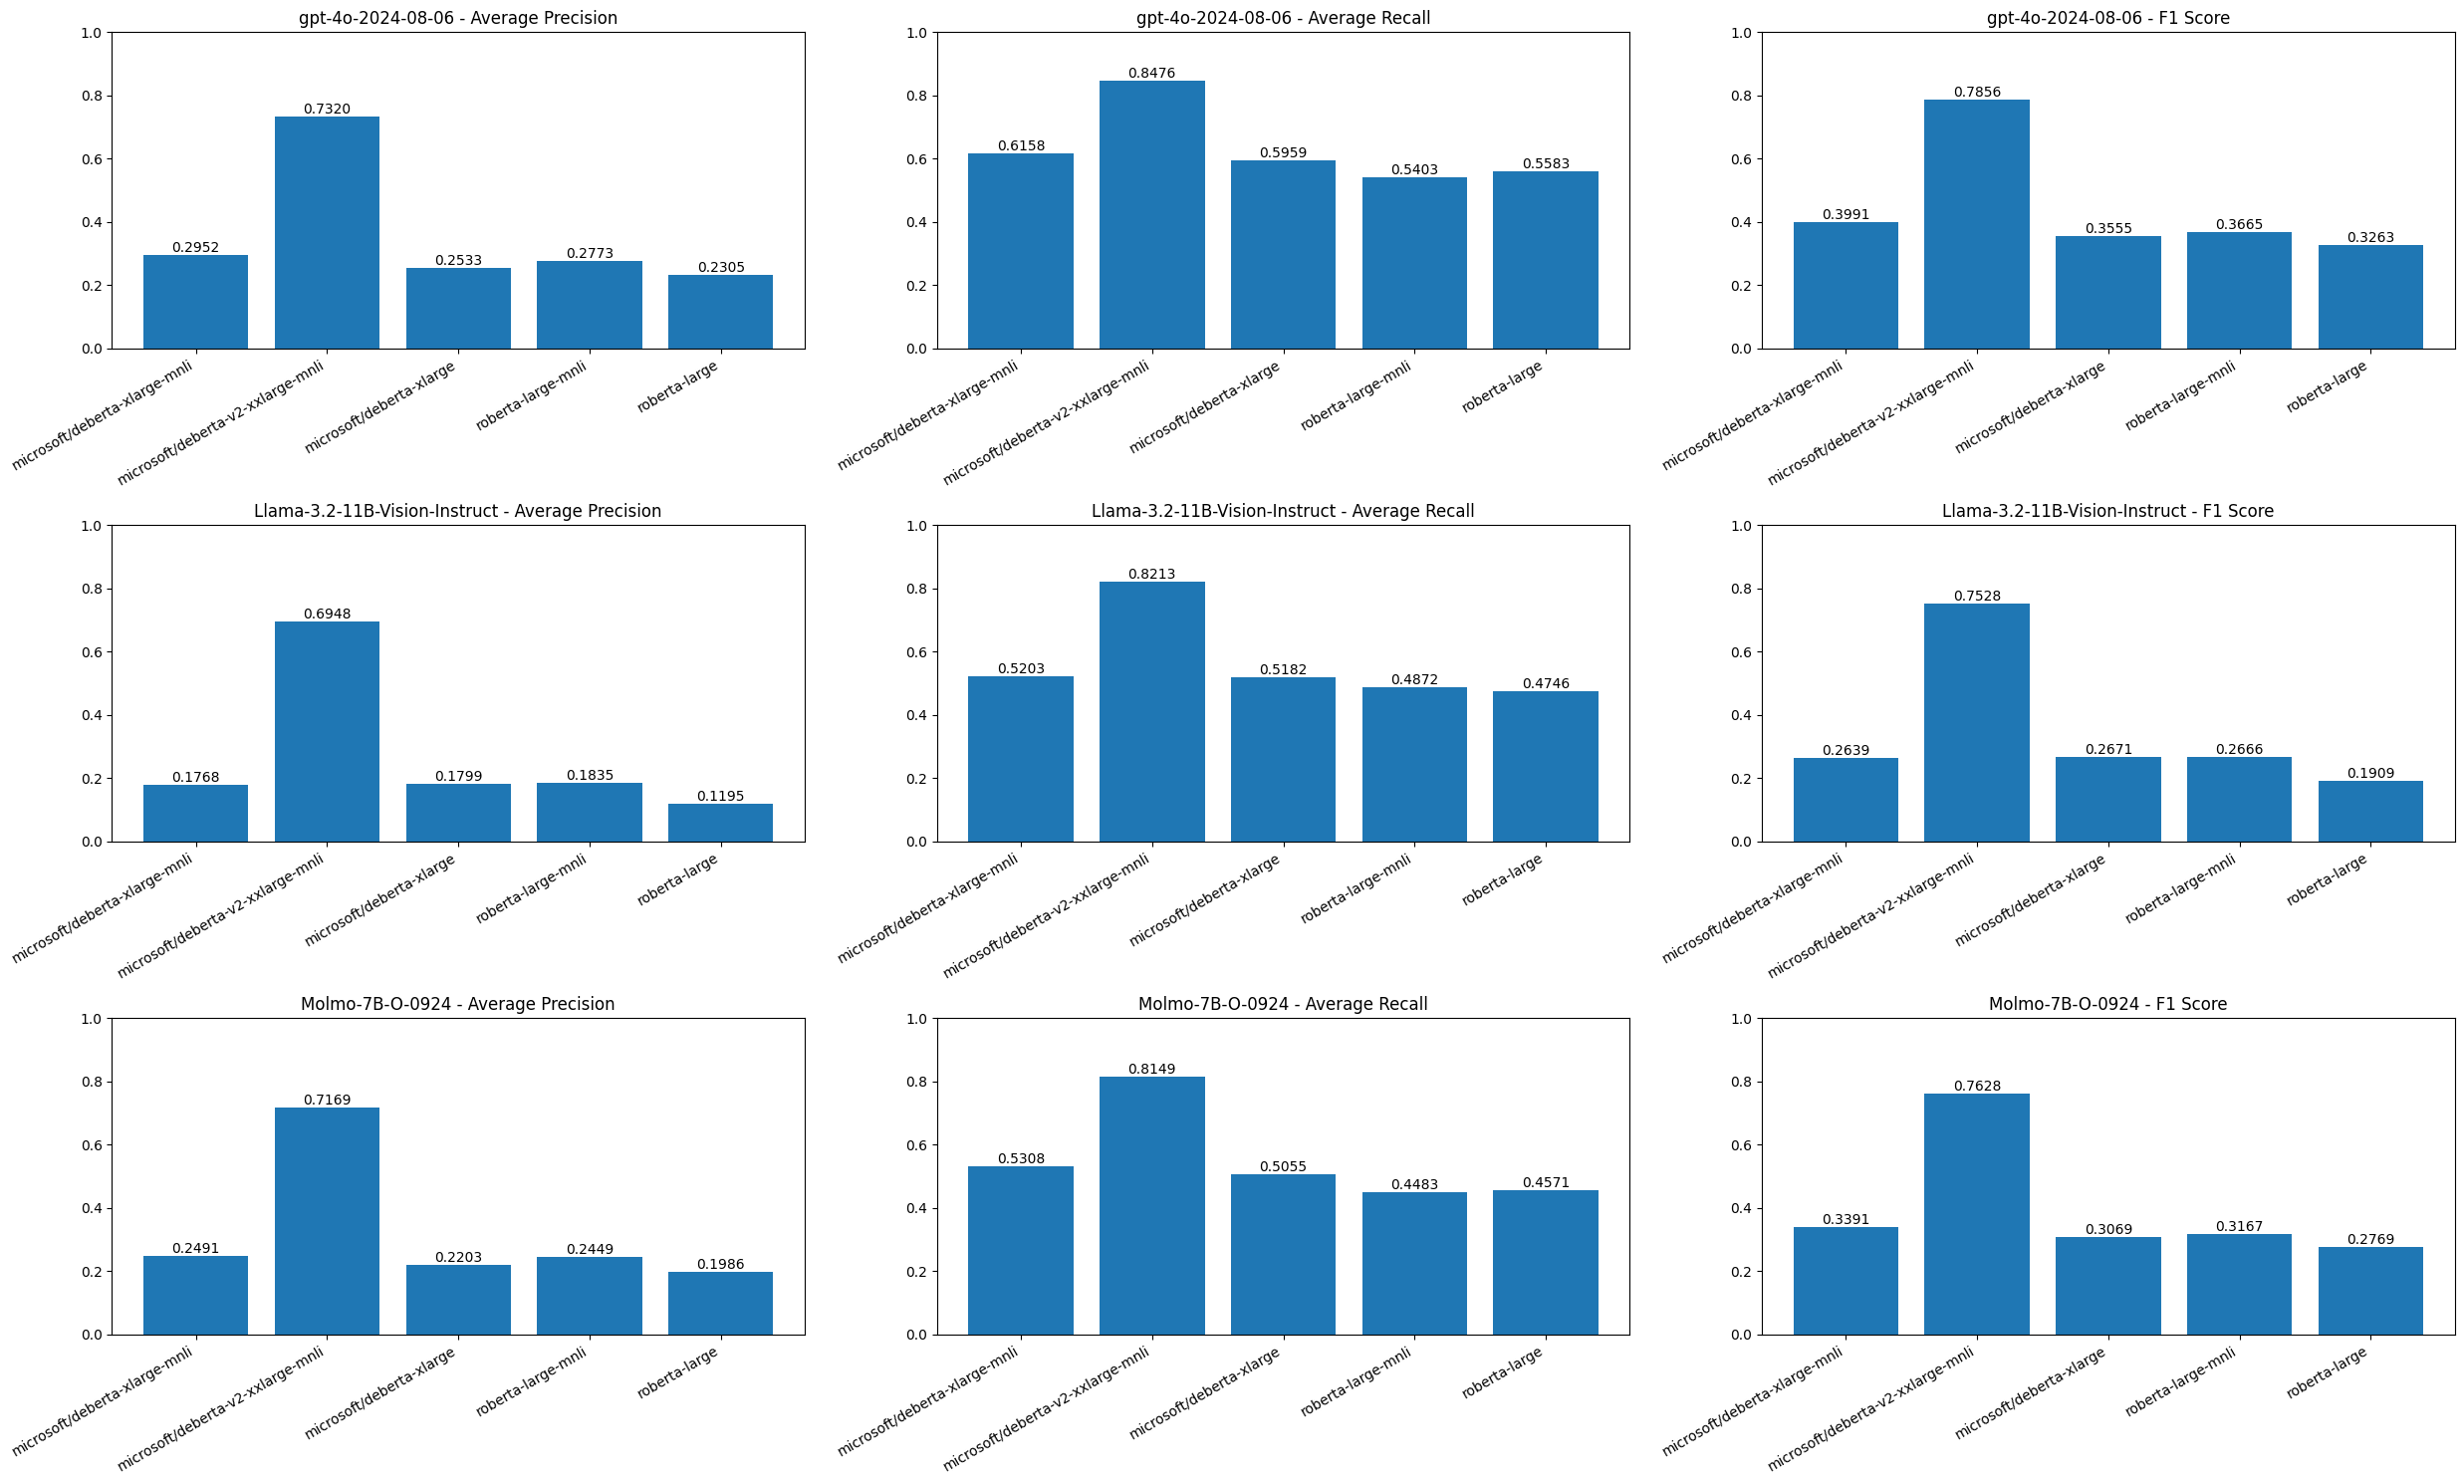

In [94]:
testset3_captioned_bertscores_per_model = test_bert_models(testset3_captioned_data)

## Test set: manually selected images
We can also test images by picking ones where a model does well and does poorly. In the following datasets, GPT-4o did relatively well with it's caption (Llama and Molmo may differ).

### Test set 4: good performance from GPT-4o

In [8]:
test_images = [
    "VizWiz_train_00000302.jpg",
    "VizWiz_train_00000416.jpg",
    "VizWiz_train_00000457.jpg",
    "VizWiz_train_00000173.jpg",
    "VizWiz_train_00000483.jpg",
    "VizWiz_train_00000088.jpg",
]
testset4_captioned_data = [
    image for image in captioned_data if image["file_name"] in test_images
]
len(testset4_captioned_data)

6

In [15]:
testset4_captioned_bertscores_per_model = test_bert_models(testset4_captioned_data)

NameError: name 'test_bert_models' is not defined

### Test set 5: poor performance from GPT-4o

In [91]:
test_images = [
    "VizWiz_train_00000205.jpg",
    "VizWiz_train_00000422.jpg",
    "VizWiz_train_00000517.jpg",
    "VizWiz_train_00000131.jpg",
    "VizWiz_train_00000189.jpg",
    "VizWiz_train_00000078.jpg",
]
testset5_captioned_data = [
    image for image in captioned_data if image["file_name"] in test_images
]
len(testset5_captioned_data)

6

In [5]:
testset5_captioned_data

NameError: name 'testset5_captioned_data' is not defined

  0%|          | 0/5 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/6w/gkg9vw3d29jglv9knrxxf3r40000gn/T/ipykernel_73544/1262268110.py:89: UserWarning: set_ticklabels() should only

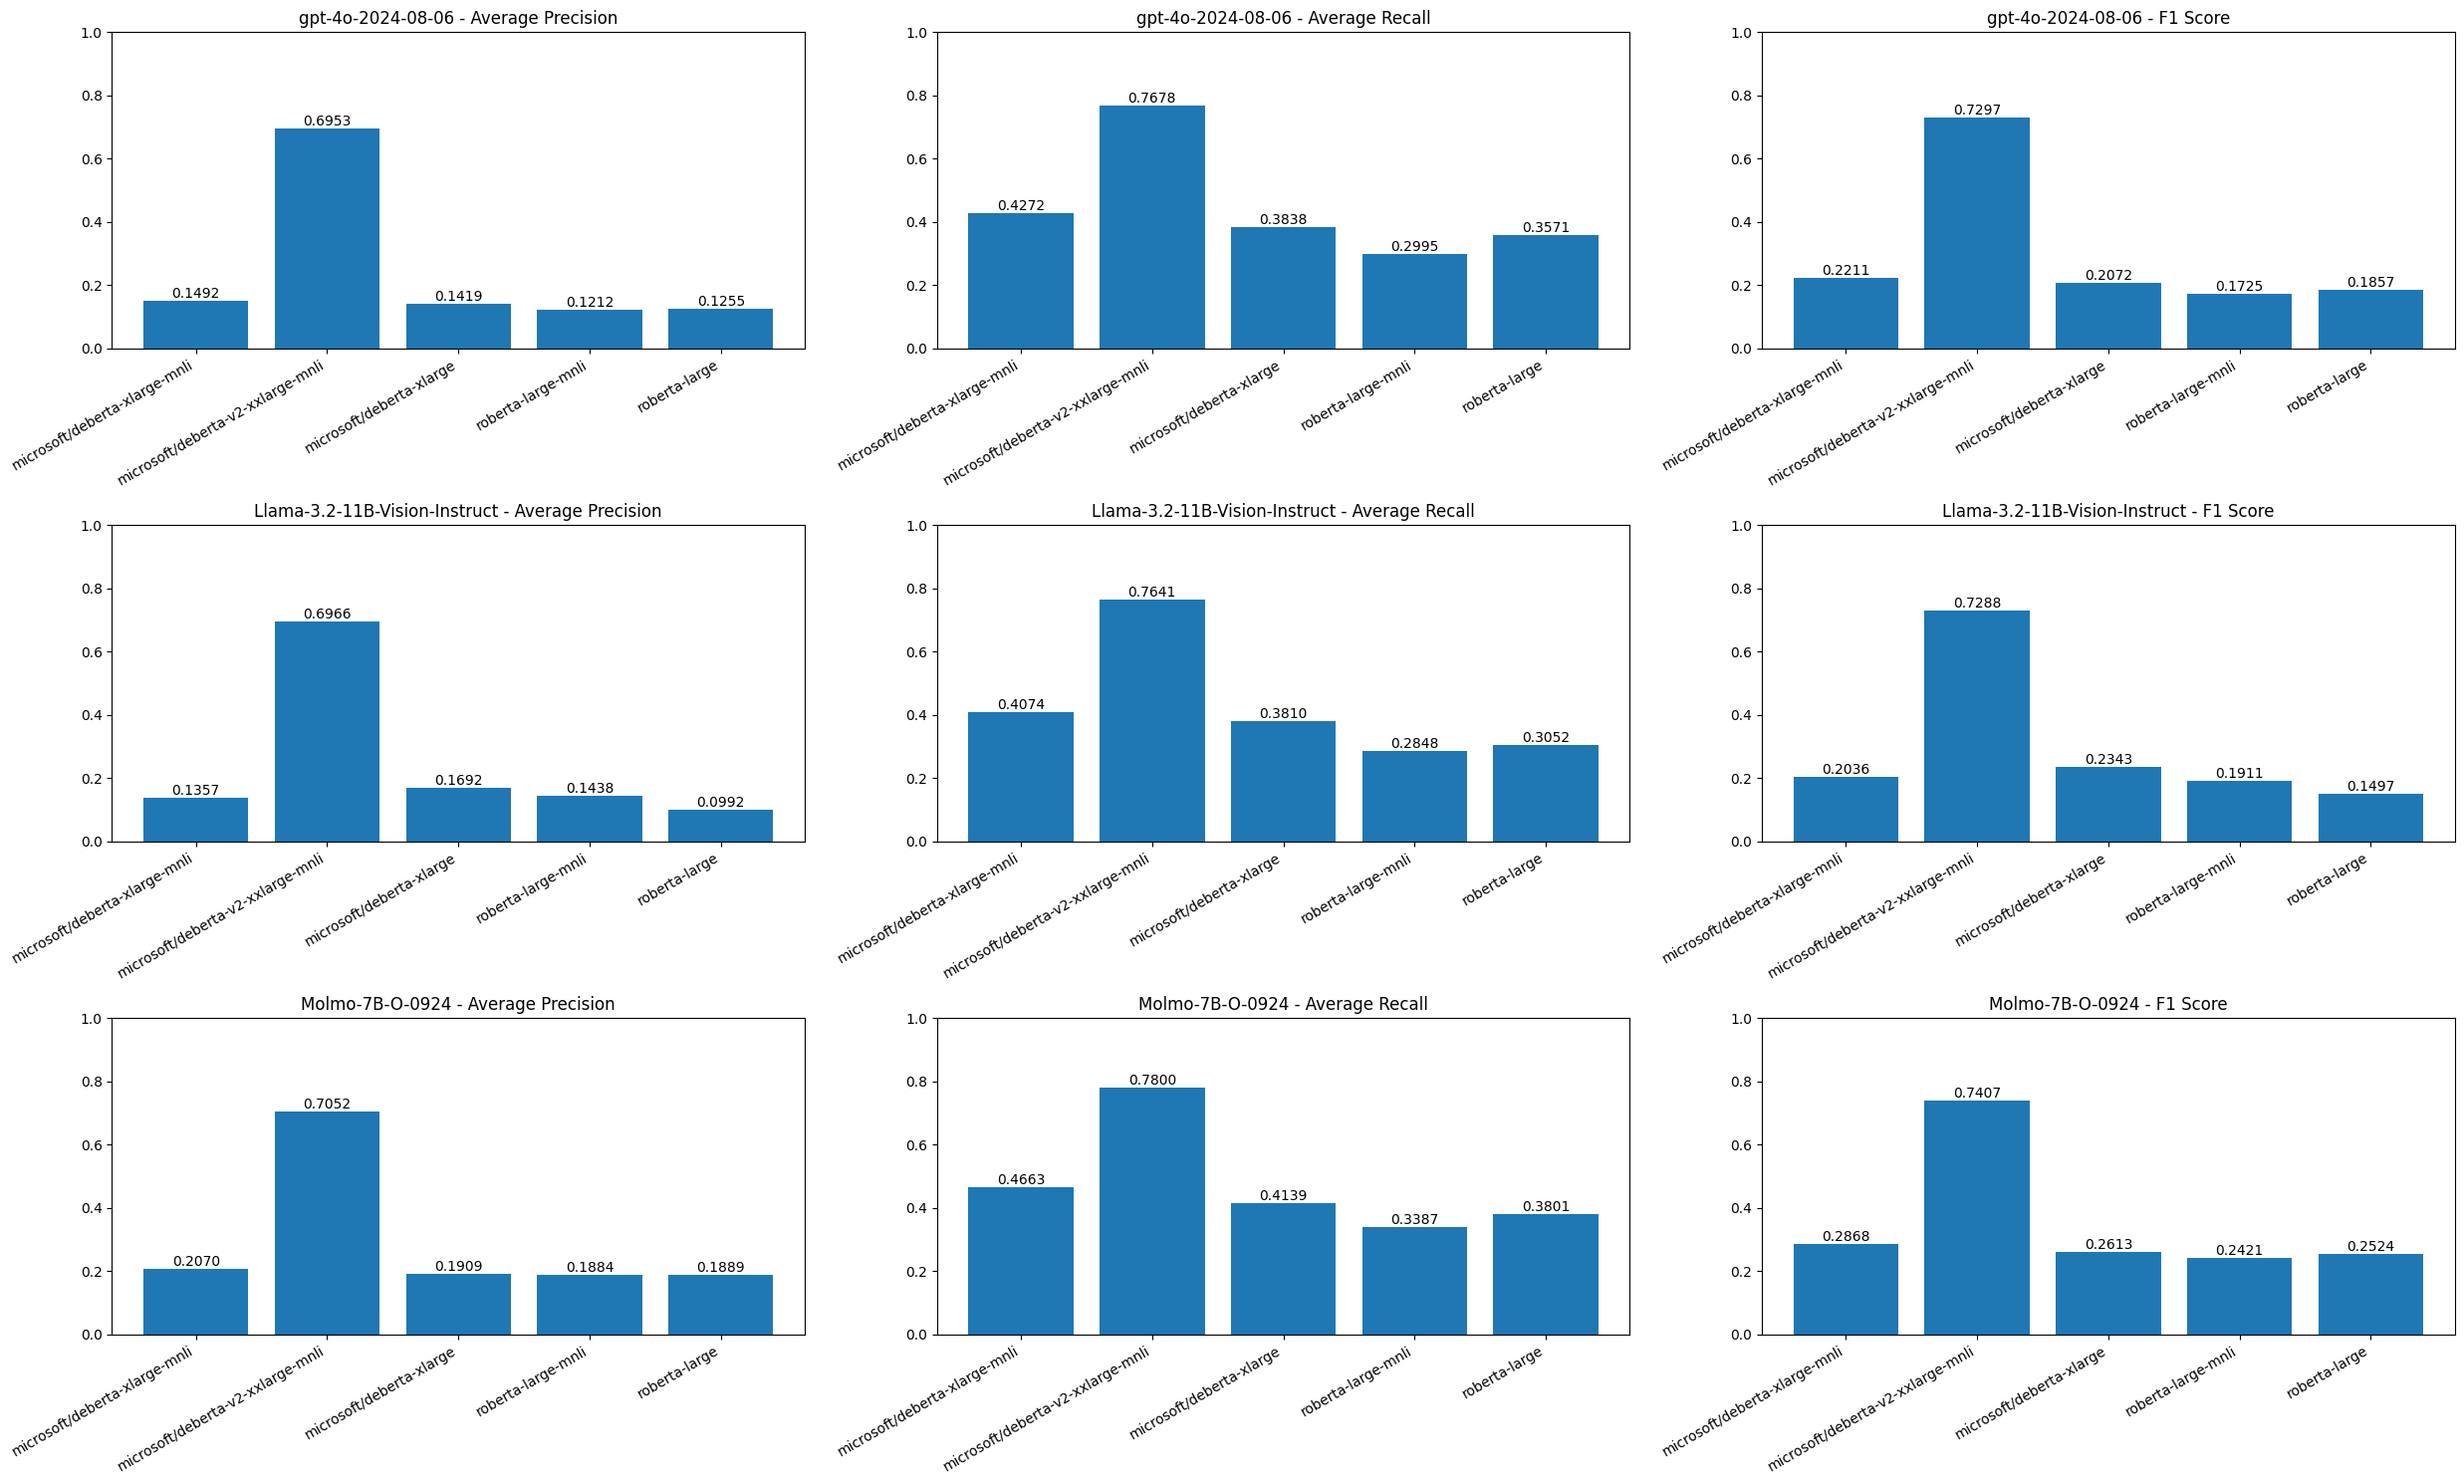

In [92]:
testset5_captioned_bertscores_per_model = test_bert_models(testset5_captioned_data)

## Conclusions
- The scores are likely fine -- BERTScore just occupies a small range of scores which makes it seem like everything is performing well, but it's not the case (i.e., they may not have the same interpretation as F1 scores in classification). Moving forward, we'll use `microsoft/deberta-xlarge-mnli`.
- `rescale_with_baseline` can make differences in scores more interpretable when looking across subsets. Based on the creator's [post](https://github.com/Tiiiger/bert_score/blob/master/journal/rescale_baseline.md), it does not affect coorelation with human judgement and thus remains a viable score after rescaling. *After discussing with Darren, we should probably leave this unscaled and just know that the score will be a small range*

# Demonstrating impact of rescaling
Let's see what happens when we re-scale BERTScore for a single dataset

These datasets are the same as the ones used in the previous section -- manually selected images where GPT-4o did well and poorly.

In [28]:
test_images_well = [
    "VizWiz_train_00000302.jpg",
    "VizWiz_train_00000416.jpg",
    "VizWiz_train_00000457.jpg",
    "VizWiz_train_00000173.jpg",
    "VizWiz_train_00000483.jpg",
    "VizWiz_train_00000088.jpg",
]
testset_well_captioned_data = [
    image for image in captioned_data if image["file_name"] in test_images_well
]
print(f"len(testset_well_captioned_data): {len(testset_well_captioned_data)}")

test_images_poor = [
    "VizWiz_train_00000205.jpg",
    "VizWiz_train_00000422.jpg",
    "VizWiz_train_00000517.jpg",
    "VizWiz_train_00000131.jpg",
    "VizWiz_train_00000189.jpg",
    "VizWiz_train_00000078.jpg",
]
testset_poor_captioned_data = [
    image for image in captioned_data if image["file_name"] in test_images_poor
]
print(f"len(testset_poor_captioned_data): {len(testset_poor_captioned_data)}")

len(testset_well_captioned_data): 6
len(testset_poor_captioned_data): 6


In [18]:
test_well_noscale = compute_bertscore_with_list(
    testset_well_captioned_data,
    model_type="microsoft/deberta-xlarge-mnli",
    lang="en",
)
test_poor_noscale = compute_bertscore_with_list(
    testset_poor_captioned_data,
    model_type="microsoft/deberta-xlarge-mnli",
    lang="en",
)
test_well_rescaled = compute_bertscore_with_list(
    testset_well_captioned_data,
    model_type="microsoft/deberta-xlarge-mnli",
    lang="en",
    rescale_with_baseline=True,
)
test_poor_rescaled = compute_bertscore_with_list(
    testset_poor_captioned_data,
    model_type="microsoft/deberta-xlarge-mnli",
    lang="en",
    rescale_with_baseline=True,
)

In [19]:
test_well_noscale

[{'image_id': 88,
  'file_name': 'VizWiz_train_00000088.jpg',
  'vizwiz_url': 'https://vizwiz.cs.colorado.edu/VizWiz_visualization_img/VizWiz_train_00000088.jpg',
  'text_detected': True,
  'unrecognizable': 0,
  'framing': 3,
  'blur': 4,
  'obstruction': 0,
  'rotation': 1,
  'too dark': 0,
  'too bright': 0,
  'other': 0,
  'no issue': 1,
  'human_captions': [{'caption': 'A very wonderful view and worth seeing at all times, my friend',
    'is_precanned': False,
    'is_rejected': True},
   {'caption': "A Mini Aquarium box rests upon a person's legs, who is wearing green shorts.",
    'is_precanned': False,
    'is_rejected': False},
   {'caption': 'A person is sitting down and has a toy box in their lap.',
    'is_precanned': False,
    'is_rejected': False},
   {'caption': "a blue box for a device that is set on someone's lap",
    'is_precanned': False,
    'is_rejected': False},
   {'caption': 'A person wearing green shorts holding a toy package.',
    'is_precanned': False,
   

In [20]:
test_poor_noscale

[{'image_id': 78,
  'file_name': 'VizWiz_train_00000078.jpg',
  'vizwiz_url': 'https://vizwiz.cs.colorado.edu/VizWiz_visualization_img/VizWiz_train_00000078.jpg',
  'text_detected': True,
  'unrecognizable': 0,
  'framing': 4,
  'blur': 5,
  'obstruction': 0,
  'rotation': 0,
  'too dark': 0,
  'too bright': 0,
  'other': 1,
  'no issue': 0,
  'human_captions': [{'caption': 'A can of mountain dew is open and on a floor.',
    'is_precanned': False,
    'is_rejected': False},
   {'caption': 'An open soda can is sitting on a table, in front of a door.',
    'is_precanned': False,
    'is_rejected': False},
   {'caption': "A regular sized can of Mountain Dew missing it's pull tab.",
    'is_precanned': False,
    'is_rejected': False},
   {'caption': 'A can of Mountain Dew with the tab opener removed.',
    'is_precanned': False,
    'is_rejected': False},
   {'caption': 'Image contain a partial part of a mountain dew cane.',
    'is_precanned': False,
    'is_rejected': False}],
  'model

In [104]:
test_well_noscale_metrics = compute_average_metrics_bertscore(test_well_noscale)
test_poor_noscale_metrics = compute_average_metrics_bertscore(test_poor_noscale)
test_well_rescaled_metrics = compute_average_metrics_bertscore(test_well_rescaled)
test_poor_rescaled_metrics = compute_average_metrics_bertscore(test_poor_rescaled)

test_poor_rescaled_metrics

{'gpt-4o-2024-08-06': {'avg_precision': 0.14916428488989672,
  'avg_recall': 0.4272071172793706,
  'avg_f1': 0.25886902461449307,
  'f1': 0.22112146407339356},
 'Llama-3.2-11B-Vision-Instruct': {'avg_precision': 0.13572465271378556,
  'avg_recall': 0.4074178437391917,
  'avg_f1': 0.24346227943897247,
  'f1': 0.2036174510815081},
 'Molmo-7B-O-0924': {'avg_precision': 0.20703640083471933,
  'avg_recall': 0.4663464029630025,
  'avg_f1': 0.3093811919291814,
  'f1': 0.28676313166048917}}

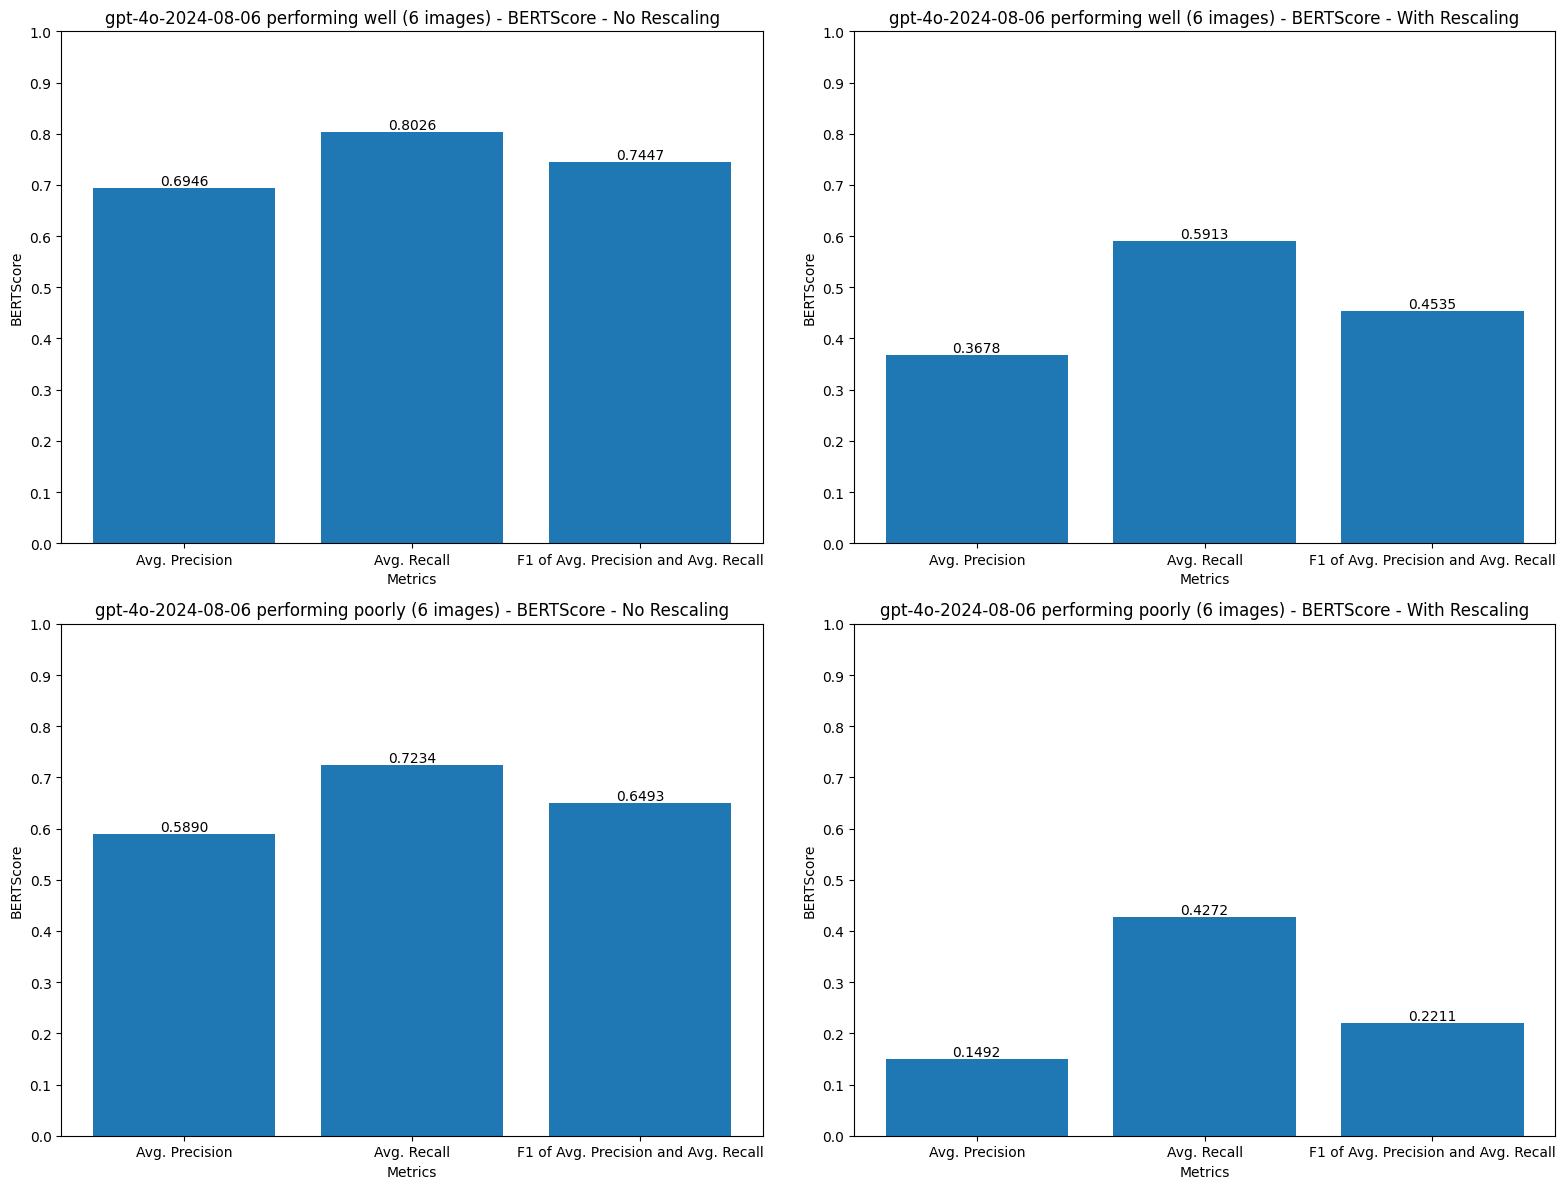

In [ ]:
# make a barplot with 2 charts -- one with no scale and one with recale -- for well
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure with 2 subplots (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Get model name - just using the first model
model_name = "gpt-4o-2024-08-06"

# First row, first subplot - Well images, No rescaling
# Extract metrics for the model
metrics_well_noscale = [
    test_well_noscale_metrics[model_name]["avg_precision"],
    test_well_noscale_metrics[model_name]["avg_recall"],
    test_well_noscale_metrics[model_name]["f1"],
]

# Create bars
x_labels = ["Avg. Precision", "Avg. Recall", "F1 of Avg. Precision and Avg. Recall"]
bars = axes[0, 0].bar(x_labels, metrics_well_noscale)

# Add labels and title
axes[0, 0].set_xlabel("Metrics")
axes[0, 0].set_ylabel("BERTScore")
axes[0, 0].set_title(
    f"{model_name} performing well ({len(testset_well_captioned_data)} images) - BERTScore - No Rescaling"
)
# Set y-axis limits and ticks
axes[0, 0].set_ylim(0, 1)
axes[0, 0].set_yticks(np.arange(0, 1.1, 0.1))

# Add text labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[0, 0].text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{metrics_well_noscale[i]:.4f}",
        ha="center",
        va="bottom",
    )

# First row, second subplot - Well images, With rescaling
# Extract metrics for the model
metrics_well_rescale = [
    test_well_rescaled_metrics[model_name]["avg_precision"],
    test_well_rescaled_metrics[model_name]["avg_recall"],
    test_well_rescaled_metrics[model_name]["f1"],
]

# Create bars
bars = axes[0, 1].bar(x_labels, metrics_well_rescale)

# Add labels and title
axes[0, 1].set_xlabel("Metrics")
axes[0, 1].set_ylabel("BERTScore")
axes[0, 1].set_title(
    f"{model_name} performing well ({len(testset_well_captioned_data)} images) - BERTScore - With Rescaling"
)
# Set y-axis limits and ticks
axes[0, 1].set_ylim(0, 1)
axes[0, 1].set_yticks(np.arange(0, 1.1, 0.1))

# Add text labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[0, 1].text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{metrics_well_rescale[i]:.4f}",
        ha="center",
        va="bottom",
    )

# Second row, first subplot - Poor images, No rescaling
# Extract metrics for the model
metrics_poor_noscale = [
    test_poor_noscale_metrics[model_name]["avg_precision"],
    test_poor_noscale_metrics[model_name]["avg_recall"],
    test_poor_noscale_metrics[model_name]["f1"],
]

# Create bars
bars = axes[1, 0].bar(x_labels, metrics_poor_noscale)

# Add labels and title
axes[1, 0].set_xlabel("Metrics")
axes[1, 0].set_ylabel("BERTScore")
axes[1, 0].set_title(
    f"{model_name} performing poorly ({len(testset_poor_captioned_data)} images) - BERTScore - No Rescaling"
)
# Set y-axis limits and ticks
axes[1, 0].set_ylim(0, 1)
axes[1, 0].set_yticks(np.arange(0, 1.1, 0.1))

# Add text labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[1, 0].text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{metrics_poor_noscale[i]:.4f}",
        ha="center",
        va="bottom",
    )

# Second row, second subplot - Poor images, With rescaling
# Extract metrics for the model
metrics_poor_rescale = [
    test_poor_rescaled_metrics[model_name]["avg_precision"],
    test_poor_rescaled_metrics[model_name]["avg_recall"],
    test_poor_rescaled_metrics[model_name]["f1"],
]

# Create bars
bars = axes[1, 1].bar(x_labels, metrics_poor_rescale)

# Add labels and title
axes[1, 1].set_xlabel("Metrics")
axes[1, 1].set_ylabel("BERTScore")
axes[1, 1].set_title(
    f"{model_name} performing poorly ({len(testset_poor_captioned_data)} images) - BERTScore - With Rescaling"
)
# Set y-axis limits and ticks
axes[1, 1].set_ylim(0, 1)
axes[1, 1].set_yticks(np.arange(0, 1.1, 0.1))

# Add text labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[1, 1].text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{metrics_poor_rescale[i]:.4f}",
        ha="center",
        va="bottom",
    )

# Adjust layout and display
plt.tight_layout()
plt.show()